In [1]:
import pandas as pd
from scripts.evaluate_model import ModelEvaluator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from scripts.train_model import optuna_xgb
import joblib


data = pd.read_csv('../data/processed/dataset_reduced.csv')

# 对 Cation, Anion 进行One-hot编码
data_encoded = pd.get_dummies(data, columns=['Cation', 'Anion'])

# 划分训练集和测试集
data_encoded['target_class'] = pd.qcut(data_encoded['Cs'], q=10, labels=False)
X = data_encoded.drop(['Cs', 'target_class'], axis=1)
y = data_encoded['Cs']
stratify_column = data_encoded['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

In [2]:
optuna_xgb(X_train, y_train, n_trials=100, model_save_path="../models/best_xgb.pkl")

[I 2025-03-12 16:57:14,715] A new study created in memory with name: no-name-34a382e6-5270-4402-90c7-f1658ae55b5b
[I 2025-03-12 16:57:15,382] Trial 0 finished with value: 0.22999397997693113 and parameters: {'learning_rate': 0.20493050845521216, 'subsample': 0.6588186172509235, 'gamma': 0.7377827582289554, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 0.03714431887875691, 'colsample_bytree': 0.5522049104193627, 'colsample_bylevel': 0.840789471348595, 'colsample_bynode': 0.8012372291557383}. Best is trial 0 with value: 0.22999397997693113.
[I 2025-03-12 16:57:16,000] Trial 1 finished with value: 0.24686308958719785 and parameters: {'learning_rate': 0.14968273998390802, 'subsample': 0.3779619637069873, 'gamma': 0.8988189584519386, 'max_depth': 8, 'min_child_weight': 9, 'reg_alpha': 0.0796677899342797, 'colsample_bytree': 0.7902234340746908, 'colsample_bylevel': 0.8353682093899795, 'colsample_bynode': 0.514602408806627}. Best is trial 0 with value: 0.22999397997693113.
[I 2025-03-12

Best trial:
  Value: 0.18283443261613658
  Params:
    learning_rate: 0.13464310396094092
    subsample: 0.7664251431686178
    gamma: 0.21227312542123994
    max_depth: 6
    min_child_weight: 3
    reg_alpha: 0.16360676354464287
    colsample_bytree: 0.9030082708979921
    colsample_bylevel: 0.9090970000481234
    colsample_bynode: 0.8630938425533088
Best model saved to: ../models/best_xgb.pkl


(<optuna.study.study.Study at 0x1f657dade20>,
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9090970000481234,
              colsample_bynode=0.8630938425533088,
              colsample_bytree=0.9030082708979921, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.21227312542123994,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13464310396094092,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...))

In [3]:
# 加载最佳模型
best_model = joblib.load("../models/best_xgb.pkl")

# 预测
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 评估
evaluator = ModelEvaluator(model_name='XGBoost', y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_test_pred=y_test_pred)
df_metrics = evaluator.metrics_to_dataframe()
df_metrics.to_csv('../results/reports/metrics_XGBoost.csv', index=False)
df_metrics

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.999,7.52,3.3,10.64,0.97,43.04,14.98,66.15


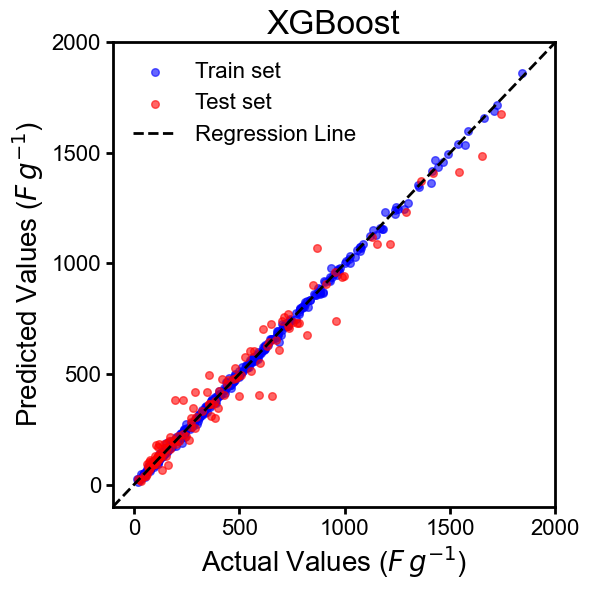

In [4]:
figpath = '../results/figures/avp_XGBoost.png'
evaluator.plot_actual_vs_predicted(figpath=figpath)

In [5]:
# Z, Period 与 CR 的相关系数过高，特征冗余
# 删除 Z, Period
X_train_r = X_train.drop(columns=['Z', 'Period'])
X_test_r = X_test.drop(columns=['Z', 'Period'])

# 重新训练模型
optuna_xgb(X_train_r, y_train, n_trials=100, model_save_path="../models/best_xgb_r.pkl")

# 加载最佳模型
best_model_r = joblib.load("../models/best_xgb_r.pkl")

# 重新预测
y_train_r_pred = best_model_r.predict(X_train_r)
y_test_r_pred = best_model_r.predict(X_test_r)

# 重新评估
evaluator_r = ModelEvaluator(model_name='XGBoost', y_train=y_train, y_train_pred=y_train_r_pred, y_test=y_test, y_test_pred=y_test_r_pred)

df_metrics_r = evaluator_r.metrics_to_dataframe()
df_metrics_r.to_csv('../results/reports/metrics_XGBoost_r.csv', index=False)
df_metrics_r

[I 2025-03-12 16:58:30,574] A new study created in memory with name: no-name-00d7842f-c706-42eb-add0-b79f28fca707
[I 2025-03-12 16:58:31,143] Trial 0 finished with value: 0.3115584000240178 and parameters: {'learning_rate': 0.09319253313428846, 'subsample': 0.6176496514425167, 'gamma': 0.05119838638362384, 'max_depth': 4, 'min_child_weight': 10, 'reg_alpha': 0.33839019341371923, 'colsample_bytree': 0.6943095231523306, 'colsample_bylevel': 0.9509414160919427, 'colsample_bynode': 0.5084111529886702}. Best is trial 0 with value: 0.3115584000240178.
[I 2025-03-12 16:58:32,136] Trial 1 finished with value: 0.23122859994793982 and parameters: {'learning_rate': 0.2743972729885229, 'subsample': 0.7620505840247918, 'gamma': 0.08528674903874889, 'max_depth': 12, 'min_child_weight': 4, 'reg_alpha': 0.5893762633743568, 'colsample_bytree': 0.7966357248454146, 'colsample_bylevel': 0.6387113905504931, 'colsample_bynode': 0.5162470469428485}. Best is trial 1 with value: 0.23122859994793982.
[I 2025-03

Best trial:
  Value: 0.19033817278504864
  Params:
    learning_rate: 0.164167865673826
    subsample: 0.6684884345922699
    gamma: 0.04196884521643485
    max_depth: 16
    min_child_weight: 4
    reg_alpha: 0.5711223350272262
    colsample_bytree: 0.768582321716204
    colsample_bylevel: 0.609462824891547
    colsample_bynode: 0.7650006980034955
Best model saved to: ../models/best_xgb_r.pkl


,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.999,7.17,2.35,13.94,0.978,39.41,15.2,56.67


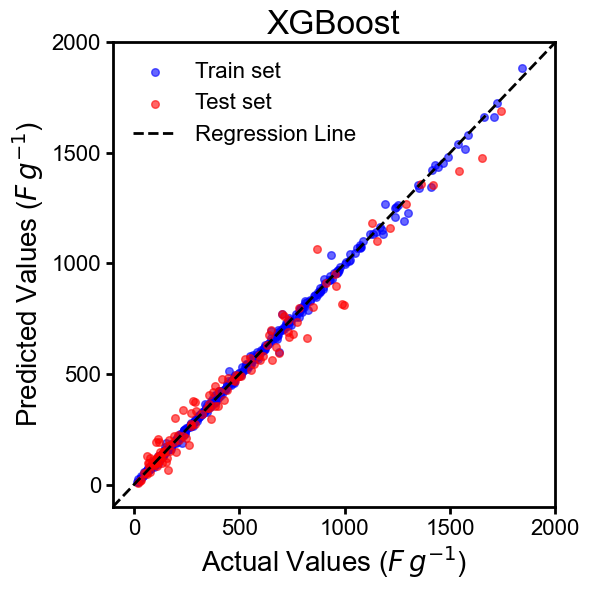

In [6]:
figpath = '../results/figures/avp_XGBoost_r.png'
evaluator_r.plot_actual_vs_predicted(figpath=figpath)